In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:

class TiPaLiDataset(Dataset):
    def __init__(self, annotations_file, img_dir, leaf_char_index=11, leaves=None,
                 tilt_norm_angle=90, ground_norm_dist=4, fov_norm_angle=10, fov_gain=1000):
        self.tilt_norm_angle = tilt_norm_angle
        self.ground_norm_dist = ground_norm_dist
        self.fov_norm_angle = fov_norm_angle
        self.fov_gain = fov_gain
        self.img_dir = img_dir
        self.img_transform = transforms.ToTensor()
        self.img_labels = pd.read_csv(annotations_file)
        if leaves is not None:
            # filter labels to only matching leaves (A, B, C, etc)
            self.img_labels = self.img_labels[self.img_labels['FILE_NAME'].str[leaf_char_index].isin(leaves)]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # creates a flattened tensor of pixel values from  0..1
        image = torch.flatten(self.img_transform(Image.open(img_path)))
        
        # normalize PAN_ANGLE, TILT_ANGLE, GROUND_DISTANCE from 0.0 to 1.0
        label = self.encode_label(self.img_labels.iloc[idx, 1:4])
        
        # auxillary data consists of normalized SAMPLE_FOV only
        aux = self.encode_aux([self.img_labels.iloc[idx,-1]])

        # concatenate image with auxillary data
        x = torch.cat((image, aux), 0)
        return x, label

    def encode_label(self, data):
        pan_angle = data['PAN_ANGLE']
        # to avoid discontinuities, encode pan as sin, cos
        pan_sin = np.sin(pan_angle * np.pi / 180)
        pan_cos = np.cos(pan_angle * np.pi / 180)
        ntilt   = (1/self.tilt_norm_angle)  * data['TILT_ANGLE']
        nground = (1/self.ground_norm_dist) * data['GROUND_DISTANCE']
        return torch.tensor([pan_sin, pan_cos, ntilt, nground]).float()

    def decode_label(self, label):
        pan_sin = label[0].item()
        pan_cos = label[1].item()
        pan = np.arctan2(pan_sin, pan_cos) * 180 / np.pi
        if pan < 0:
            pan += 360
        tilt   = self.tilt_norm_angle * label[2].item()
        ground = self.ground_norm_dist * label[3].item()
        return [pan, tilt, ground]

    def encode_aux(self, data):
        nfov = self.fov_gain * (1/self.fov_norm_angle) * data[0]
        return torch.tensor([nfov]).float()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100 + 1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

def train(dataloader, model, loss_fn, optimizer, quiet=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if not quiet and batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    if not quiet:
        print(f"Training Error: \n Avg loss: {train_loss / num_batches:>8f}")
    return train_loss / num_batches

def test(dataloader, model, loss_fn, quiet=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 
    pan_errors = []
    tilt_errors = [] 
    ground_errors =[]
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # y and pred are batched, so process each individually
            for i in range(len(y)):
                pred_pan, pred_tilt, pred_ground = test_data.decode_label(pred[i])
                pan, tilt, ground = test_data.decode_label(y[i])
                pe = pred_pan - pan
                if pe > 180:
                    pe = pe - 360
                elif pe < -180:
                    pe = pe + 360
                pan_errors.append(pe)
                tilt_errors.append(pred_tilt - tilt)
                ground_errors.append(pred_ground - ground)
    test_loss /= num_batches
    mpe = np.mean(pan_errors)
    mte = np.mean(tilt_errors)
    mge = np.mean(ground_errors)
    spe = np.std(pan_errors)
    ste = np.std(tilt_errors)
    sge = np.std(ground_errors)
    if not quiet:
        print(f"Test Error: \n Avg loss: {test_loss:>8f}")
        print(f" Pan    Error Mean: {mpe:>8f} StdDev: {spe:>8f}")
        print(f" Tilt   Error Mean: {mte:>8f} StdDev: {ste:>8f}")
        print(f" Ground Error Mean: {mge:>8f} StdDev: {sge:>8f}")
    return test_loss, mpe, mte, mge, spe, ste, sge

class TrainingStats:
    def __init__(self):
        self.data = [] # does not include epoch
        self.headers = ['Epoch', 'Training Loss', 'Test Loss', 
                        'Test Pan Error Mean', 'Test Tilt Error Mean', 'Test Ground Distance Error Mean', 
                        'Test Pan Error Stddev', 'Test Tilt Error Stddev', 'Test Ground Distance Error Stddev']
    def add(self, stats):
        self.data.append(stats)
    def getDataFrame(self):
        data_with_epoch = [[i + 1] + list(self.data[i]) for i in range(len(self.data))]
        df = pd.DataFrame(data_with_epoch, columns = self.headers)
        df.set_index('Epoch', inplace=True)
        return df
    def save(self, path):
        df = self.getDataFrame()
        df.to_csv(path)
    def read(self, path):
        df = pd.read_csv(path)
        df.set_index('Epoch', inplace=True)
        self.data.extend(df.values)

def trainAndEvaluateModel(model, train_dataloader, test_dataloader, loss_fun, optimizer, stats=None,
                          epochs=5, report_interval=1):
    for epoch in range(1, epochs+1):
        start_time = time.time()
        # always report the first and last epoch
        is_quiet = epoch % report_interval != 0 and epoch != epochs and epoch != 1
        if not is_quiet:
            print(f"Epoch {epoch}\n-------------------------------")
        train_loss = train(train_dataloader, model, mse_loss, optimizer, is_quiet)
        test_stats = test(test_dataloader, model, mse_loss, is_quiet)
        if stats is not None:
            stats.add([train_loss] + list(test_stats))
        elapsed_time = time.time() - start_time
        if not is_quiet:
            print(f"Elapsed time: {elapsed_time} seconds")
    print("Done!")

In [3]:
training_data = TiPaLiDataset('final_data.csv',
                              'ScienceFairData_Processed',
                                   leaves=['A','B','C','D','F','G','I'])
test_data = TiPaLiDataset('final_data.csv',
                          'ScienceFairData_Processed',
                                   leaves=['E','H'])

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

device = 'cpu'

model = NeuralNetwork().to(device)
print(model)

mse_loss = nn.MSELoss()

stats = TrainingStats()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10001, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [4]:
# restore latest model weights and training statistics from previous training sessions
# last_session lr=0.0001, 13600 epochs
last_session = 'L0001_13600' # lr=0.0001, 5600 epochs
model.load_state_dict(torch.load(f'model_weights_{last_session}.pth', weights_only=True))
model.eval()
test(test_dataloader, model, mse_loss)
stats = TrainingStats()
stats.read(f'model_stats_{last_session}.csv')

Test Error: 
 Avg loss: 0.092407
 Pan    Error Mean: -12.392923 StdDev: 42.304866
 Tilt   Error Mean: -2.087088 StdDev: 4.643367
 Ground Error Mean: 0.074445 StdDev: 0.205435


Average 17.5 sec per epoch, ~ 200 epochs per hour

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
trainAndEvaluateModel(model, train_dataloader, test_dataloader, 
                      mse_loss, optimizer, stats, epochs=20*200, report_interval=100)

Epoch 1
-------------------------------
loss: 0.003262  [   64/20271]
loss: 0.004460  [ 6464/20271]
loss: 0.005467  [12864/20271]
loss: 0.002880  [19264/20271]
Training Error: 
 Avg loss: 0.003994
Test Error: 
 Avg loss: 0.091516
 Pan    Error Mean: -12.347423 StdDev: 41.815214
 Tilt   Error Mean: -1.123302 StdDev: 4.263030
 Ground Error Mean: 0.052363 StdDev: 0.206289
Elapsed time: 15.070184469223022 seconds
Epoch 100
-------------------------------
loss: 0.004798  [   64/20271]
loss: 0.002399  [ 6464/20271]
loss: 0.003541  [12864/20271]
loss: 0.003145  [19264/20271]
Training Error: 
 Avg loss: 0.003991
Test Error: 
 Avg loss: 0.094243
 Pan    Error Mean: -12.446165 StdDev: 42.922330
 Tilt   Error Mean: -1.512011 StdDev: 4.326336
 Ground Error Mean: 0.052976 StdDev: 0.205775
Elapsed time: 15.086205959320068 seconds
Epoch 200
-------------------------------
loss: 0.006316  [   64/20271]
loss: 0.007596  [ 6464/20271]
loss: 0.003190  [12864/20271]
loss: 0.004807  [19264/20271]
Training E

In [31]:
# save the new training stats
session = 'L0001_' + str(len(stats.data))
print(f'Saving model_weights_{session}.pth and model_stats_{session}.csv')
torch.save(model.state_dict(), f'model_weights_{session}.pth')
stats.save(f'model_stats_{session}.csv')

Saving model_weights_L0001_13600.pth and model_stats_L0001_13600.csv


In [5]:
df = stats.getDataFrame()
df

,Training Loss,Test Loss,Test Pan Error Mean,Test Tilt Error Mean,Test Ground Distance Error Mean,Test Pan Error Stddev,Test Tilt Error Stddev,Test Ground Distance Error Stddev
Epoch,,,,,,,,
1,0.300950,0.297690,3.431819,-2.321335,-0.798863,105.742770,6.429133,1.503011
2,0.291910,0.299438,-3.755964,-3.810078,-0.986963,103.661913,6.755577,1.303212
3,0.287891,0.289132,-0.627410,-1.760406,-0.682105,101.224647,6.260202,1.374910
4,0.283976,0.287662,0.682427,-2.545495,-0.815781,101.444727,6.335219,1.218007
5,0.280925,0.286489,-0.532349,0.566228,-0.817767,101.242075,5.969496,1.147370
...,...,...,...,...,...,...,...,...
13596,0.002954,0.090814,-12.367148,-1.333869,0.056129,41.958555,4.245124,0.202328
13597,0.002959,0.090750,-12.964084,-1.612448,0.048927,41.749170,4.462651,0.202066
13598,0.002971,0.091280,-12.685004,-1.394414,0.061645,41.898977,4.286847,0.202554


<Axes: title={'center': 'Loss'}, xlabel='Epoch'>

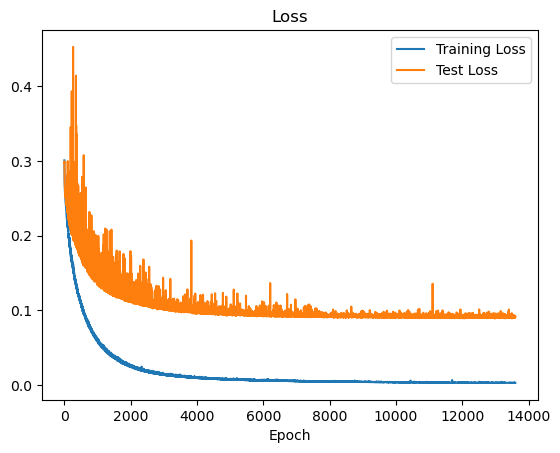

In [7]:
df[['Training Loss', 'Test Loss']].plot(title='Loss')

<Axes: title={'center': 'Test Pan Error'}, xlabel='Epoch'>

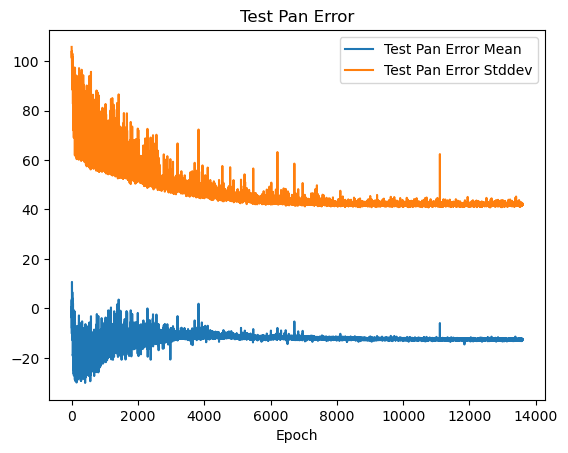

In [8]:
df[['Test Pan Error Mean', 'Test Pan Error Stddev']].plot(title='Test Pan Error')

<Axes: title={'center': 'Test Tilt Error'}, xlabel='Epoch'>

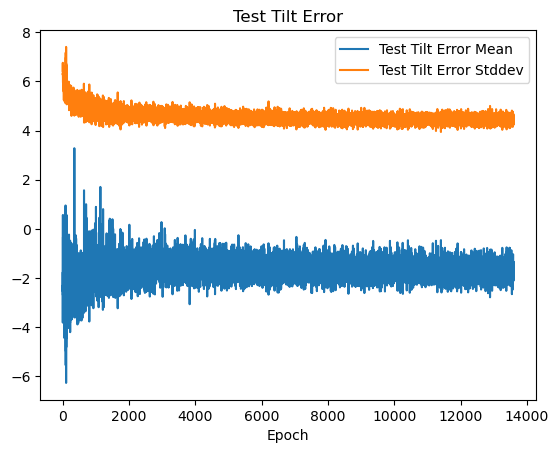

In [9]:
df[['Test Tilt Error Mean', 'Test Tilt Error Stddev']].plot(title='Test Tilt Error')

<Axes: title={'center': 'Test Ground Distance Error'}, xlabel='Epoch'>

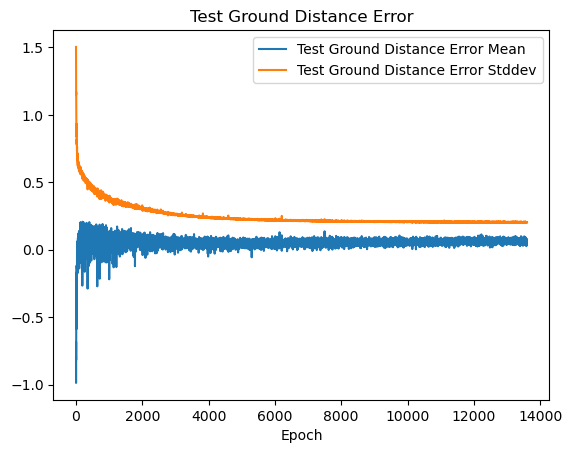

In [10]:
df[['Test Ground Distance Error Mean', 'Test Ground Distance Error Stddev']].plot(title='Test Ground Distance Error')

In [11]:
training_data.img_labels

,FILE_NAME,PAN_ANGLE,TILT_ANGLE,GROUND_DISTANCE,SLOPE_DISTANCE,SAMPLE_FOV
0,final_leaf_A_1_0223.jpg,60.800000,72.123077,0.298052,1.043473,8.095956
1,final_leaf_A_1_0224.jpg,70.523077,72.123077,0.298052,1.043473,9.224081
2,final_leaf_A_1_0225.jpg,80.738462,72.123077,0.298052,1.043473,10.086765
3,final_leaf_A_1_0226.jpg,90.584615,72.123077,0.298052,1.043473,10.617647
4,final_leaf_A_1_0227.jpg,100.800000,72.123077,0.298052,1.043473,9.224081
...,...,...,...,...,...,...
25594,final_leaf_I_1_1868.jpg,675.446154,21.046154,2.501031,2.693539,3.273775
25595,final_leaf_I_1_1869.jpg,687.384615,21.046154,2.501031,2.693539,2.919853
25596,final_leaf_I_1_1870.jpg,695.876923,21.046154,2.501031,2.693539,2.499571
25597,final_leaf_I_1_1871.jpg,705.353846,21.046154,2.501031,2.693539,2.433211


In [12]:
test_data.img_labels

,FILE_NAME,PAN_ANGLE,TILT_ANGLE,GROUND_DISTANCE,SLOPE_DISTANCE,SAMPLE_FOV
11199,final_leaf_E_1_0001.jpg,1.600000,89.846154,0.000000,1.000000,10.949449
11200,final_leaf_E_1_0002.jpg,10.215385,89.846154,0.000000,1.000000,10.838848
11201,final_leaf_E_1_0003.jpg,20.923077,89.846154,0.000000,1.000000,10.551287
11202,final_leaf_E_1_0004.jpg,30.276923,89.846154,0.000000,1.000000,9.821324
11203,final_leaf_E_1_0005.jpg,40.369231,89.846154,0.000000,1.000000,9.954044
...,...,...,...,...,...,...
23722,final_leaf_H_1_2660.jpg,675.446154,14.769231,3.602229,3.738456,1.747488
23723,final_leaf_H_1_2661.jpg,686.030769,14.769231,3.602229,3.738456,1.570527
23724,final_leaf_H_1_2662.jpg,695.015385,14.769231,3.602229,3.738456,1.526287
23725,final_leaf_H_1_2663.jpg,705.600000,14.769231,3.602229,3.738456,1.526287


In [13]:
test_data.img_labels.iloc[1500, 1:4]

PAN_ANGLE          605.538462
TILT_ANGLE          26.461538
GROUND_DISTANCE      1.998311
Name: 12699, dtype: object

In [14]:
test_data.encode_label(test_data.img_labels.iloc[1500, 1:4])

tensor([-0.9102, -0.4141,  0.2940,  0.4996])

In [15]:
test_data.decode_label(test_data.encode_label(test_data.img_labels.iloc[1500, 1:4]))

[np.float64(245.53846149220453), 26.461539566516876, 1.998311161994934]

In [16]:
def errorReportByDistance(dataloader, model, distance_bins):
    size = len(dataloader.dataset)
    model.eval()
    distances = []
    pan_errors = []
    tilt_errors = [] 
    ground_errors =[]
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y and pred are batched, so process each individually
            for i in range(len(y)):
                pred_pan, pred_tilt, pred_ground = test_data.decode_label(pred[i])
                pan, tilt, ground = test_data.decode_label(y[i])
                pe = pred_pan - pan
                if pe > 180:
                    pe = pe - 360
                elif pe < -180:
                    pe = pe + 360
                pan_errors.append(pe)
                tilt_errors.append(pred_tilt - tilt)
                ground_errors.append(pred_ground - ground)
                distances.append(ground)
    df = pd.DataFrame({'Ground Distance': distances, 'Pan Error': pan_errors, 
                       'Tilt Error': tilt_errors, 'Ground Distance Error': ground_errors})
    df = df.sort_values(by='Ground Distance')
    df['Ground Distance Bin'] = pd.cut(df['Ground Distance'], distance_bins)
    return df

def errorBoxPlot(df, column, by_column):
    p = df.boxplot(column, by=by_column)
    p.set_xticks(p.get_xticks())  # Ensure rotation is applied to all ticks
    p.set_xticklabels(p.get_xticklabels(), rotation=45, ha='right')
    plt.show()

In [17]:
test_error_df = errorReportByDistance(test_dataloader, model, np.arange(-0.05, 3.95, 0.20))

In [18]:
test_error_df

,Ground Distance,Pan Error,Tilt Error,Ground Distance Error,Ground Distance Bin
4274,0.000000,-9.567304,-16.285263,0.376572,"(-0.05, 0.15]"
2517,0.000000,10.157743,-13.223392,0.090383,"(-0.05, 0.15]"
2528,0.000000,-0.181921,-15.443264,0.271249,"(-0.05, 0.15]"
2533,0.000000,-18.399154,-15.803484,0.078751,"(-0.05, 0.15]"
2798,0.000000,-27.618140,-18.508481,0.384420,"(-0.05, 0.15]"
...,...,...,...,...,...
850,3.602229,-21.385597,0.770891,-0.005516,"(3.55, 3.75]"
2035,3.602229,-166.887072,0.925347,-0.161261,"(3.55, 3.75]"
3281,3.602229,173.564416,-0.163306,-0.437214,"(3.55, 3.75]"
650,3.602229,-10.409101,0.277361,-0.055861,"(3.55, 3.75]"


<Axes: xlabel='Ground Distance', ylabel='Pan Error'>

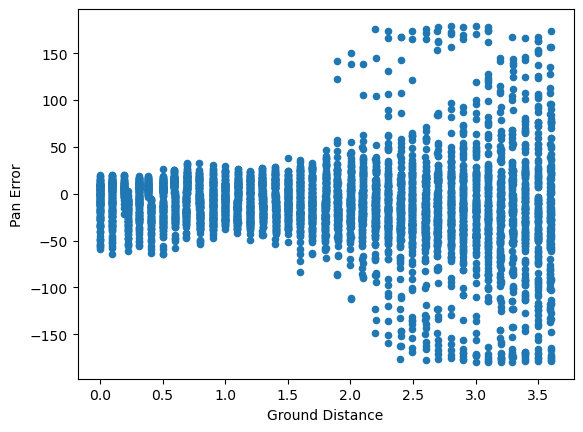

In [19]:
test_error_df.plot.scatter(x='Ground Distance', y='Pan Error')

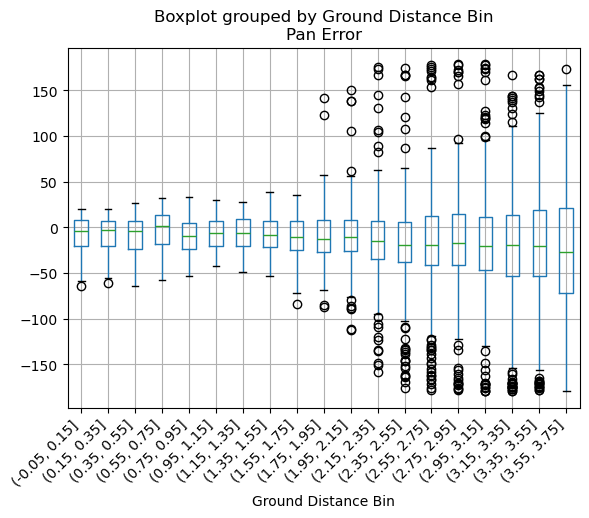

In [20]:
errorBoxPlot(test_error_df, 'Pan Error', 'Ground Distance Bin')

<Axes: xlabel='Ground Distance', ylabel='Tilt Error'>

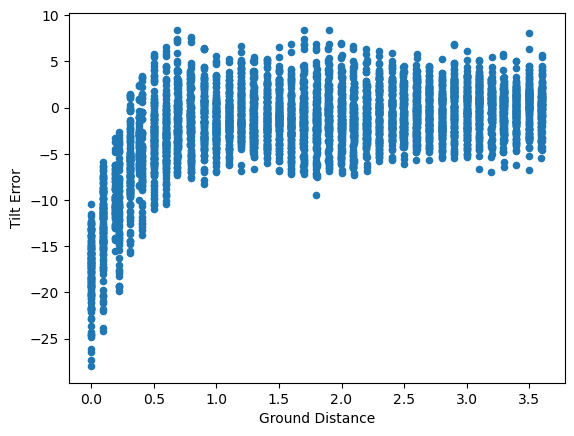

In [21]:
test_error_df.plot.scatter(x='Ground Distance', y='Tilt Error')

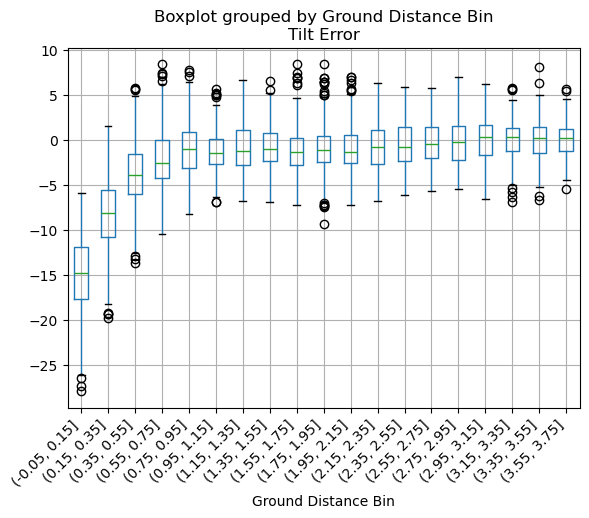

In [22]:
errorBoxPlot(test_error_df, 'Tilt Error', 'Ground Distance Bin')

<Axes: xlabel='Ground Distance', ylabel='Ground Distance Error'>

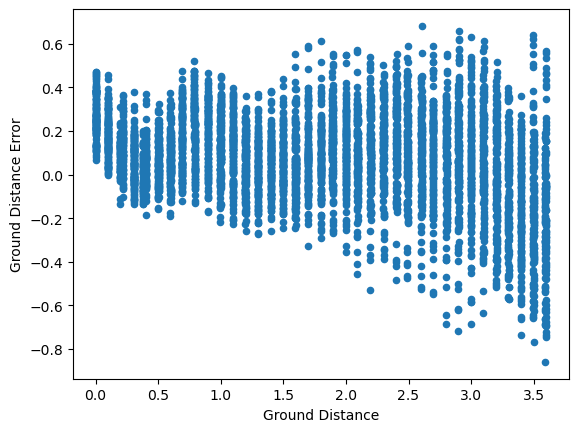

In [23]:
test_error_df.plot.scatter(x='Ground Distance', y='Ground Distance Error')

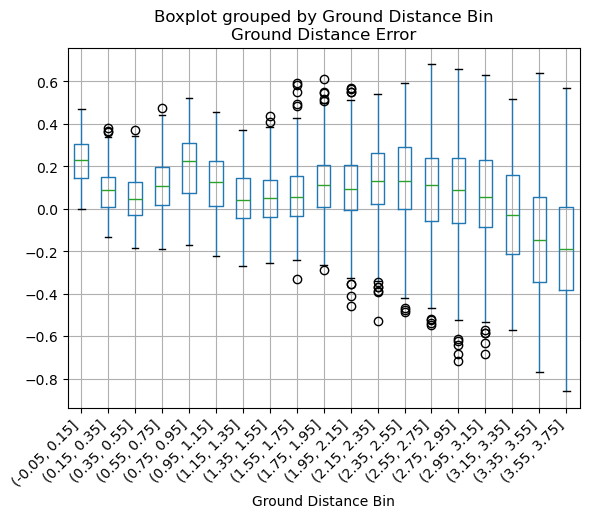

In [24]:
errorBoxPlot(test_error_df, 'Ground Distance Error', 'Ground Distance Bin')

In [25]:
train_error_df = errorReportByDistance(train_dataloader, model, np.arange(-0.05, 3.95, 0.20))

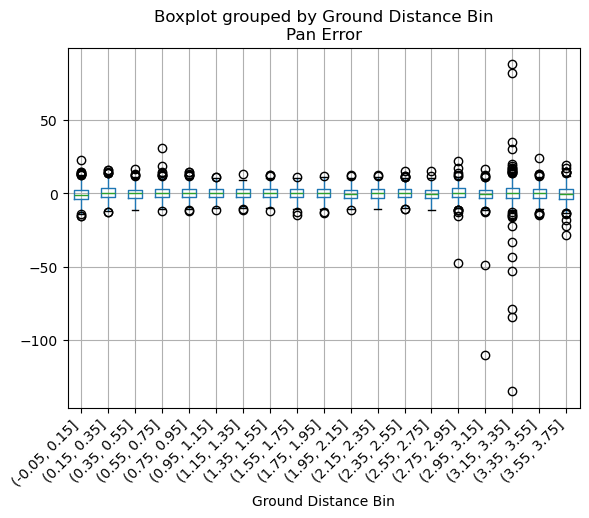

In [26]:
errorBoxPlot(train_error_df, 'Pan Error', 'Ground Distance Bin')

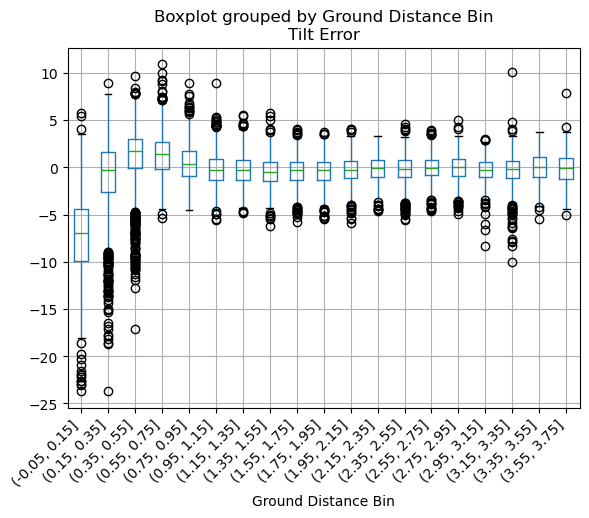

In [27]:
errorBoxPlot(train_error_df, 'Tilt Error', 'Ground Distance Bin')

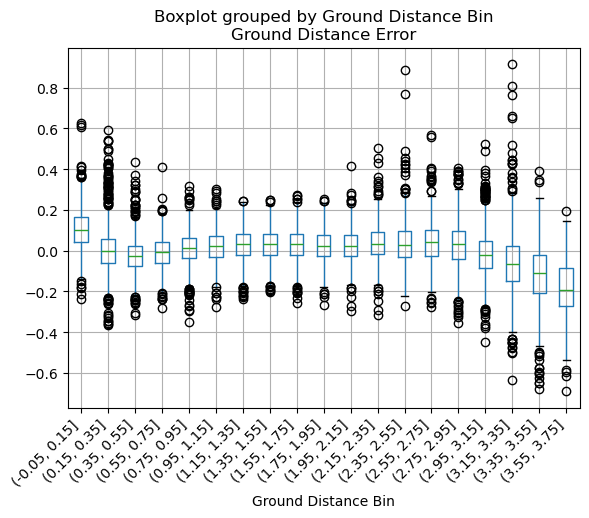

In [28]:
errorBoxPlot(train_error_df, 'Ground Distance Error', 'Ground Distance Bin')

<Axes: xlabel='Ground Distance', ylabel='Pan Error'>

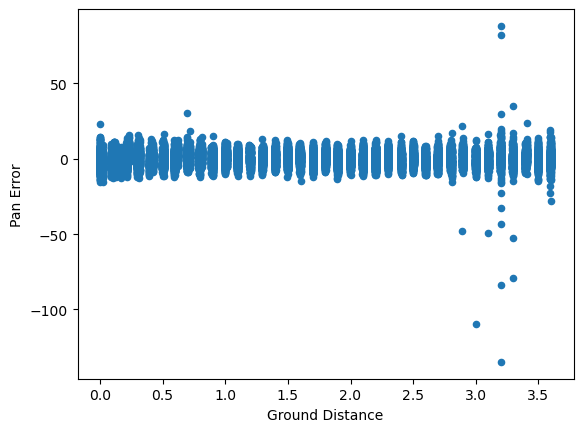

In [29]:
train_error_df.plot.scatter(x='Ground Distance', y='Pan Error')

<Axes: xlabel='Ground Distance', ylabel='Tilt Error'>

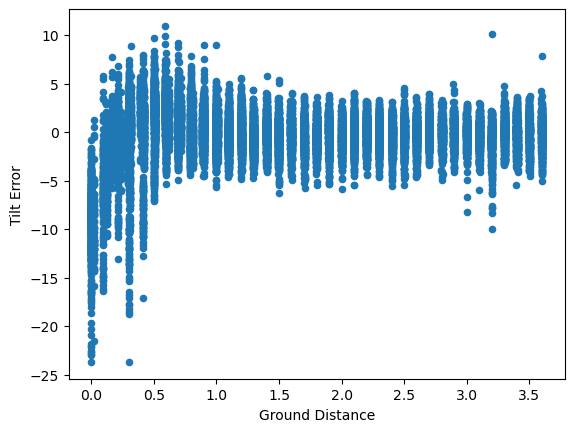

In [30]:
train_error_df.plot.scatter(x='Ground Distance', y='Tilt Error')

<Axes: xlabel='Ground Distance', ylabel='Ground Distance Error'>

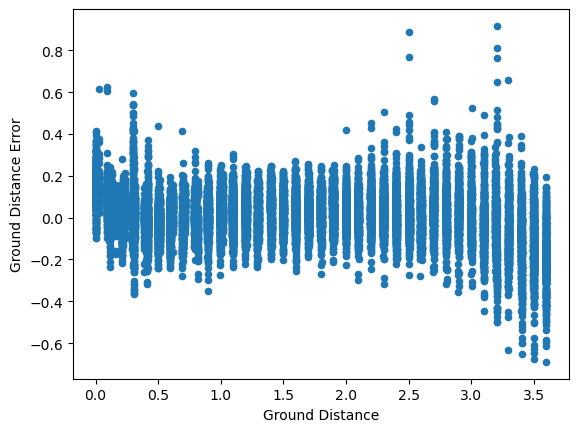

In [31]:
train_error_df.plot.scatter(x='Ground Distance', y='Ground Distance Error')